---
syncID: 19e0b890b3c64f46b2189c8273a2e0a4
title: "Calculate NDVI & Extract Spectra Using Masks in Python - Tiled Data"
description: "Learn to calculate Normalized Difference Vegetation Index (NDVI) and extract spectral using masks with Python and NEON tiled hyperspectral data products." 
dateCreated: 2018-07-05 
authors: Bridget Hass
contributors: 
estimatedTime: 
packagesLibraries: numpy, h5py, gdal, matplotlib.pyplot
topics: hyperspectral-remote-sensing, HDF5, remote-sensing, 
languagesTool: python
dataProduct: NEON.DP3.30006, NEON.DP3.30008
code1: Python/remote-sensing/hyperspectral-data/Calc_NDVI_Extract_Spectra_Masks_Tiles_py.ipynb
tutorialSeries: intro-hsi-py-series
urlTitle: calc-ndvi-tiles-py
---

In this tutorial, we will calculate the Normalized Difference Vegetation Index 
(NDVI). 

This tutorial uses the mosaiced or tiled NEON data product. For a tutorial 
using the flightline data, please see <a href="/calc-ndvi-py" target="_blank"> Calculate NDVI & Extract Spectra Using Masks in Python - Flightline Data</a>.


<div id="ds-objectives" markdown="1">

### Objectives
After completing this tutorial, you will be able to:

* Calculate NDVI from hyperspectral data in Python.

### Install Python Packages

* **numpy**
* **pandas**
* **gdal** 
* **matplotlib** 
* **h5py**


### Download Data

{% include/dataSubsets/_data_DI18.html %}

[[nid:7489]]

</div>


# Calculate NDVI & Extract Spectra with Masks

## Background:
The Normalized Difference Vegetation Index (NDVI) is a standard band-ratio calculation frequently used to analyze ecological remote sensing data. NDVI indicates whether the remotely-sensed target contains live green vegetation. When sunlight strikes objects, certain wavelengths of the electromagnetic spectrum are absorbed and other wavelengths are reflected. The pigment chlorophyll in plant leaves strongly absorbs visible light (with wavelengths in the range of 400-700 nm) for use in photosynthesis. The cell structure of the leaves, however, strongly reflects near-infrared light (wavelengths ranging from 700 - 1100 nm). Plants reflect up to 60% more light in the near infrared portion of the spectrum than they do in the green portion of the spectrum. By calculating the ratio of Near Infrared (NIR) to Visible (VIS) bands in hyperspectral data, we can obtain a metric of vegetation density and health.  

The formula for NDVI is: $$NDVI = \frac{(NIR - VIS)}{(NIR+ VIS)}$$

<figure>
	<a href="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/dev-aten/graphics/hyperspectral/ndvi_tree.png">
	<img src="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/dev-aten/graphics/hyperspectral/ndvi_tree.png"></a>
	<figcaption> NDVI is calculated from the visible and near-infrared light
    reflected by vegetation. Healthy vegetation (left) absorbs most of the
    visible light that hits it, and reflects a large portion of
    near-infrared light. Unhealthy or sparse vegetation (right) reflects more
    visible light and less near-infrared light. Source: <a href="https://www.researchgate.net/figure/266947355_fig1_Figure-1-Green-vegetation-left-absorbs-visible-light-and-reflects-near-infrared-light" target="_blank">Figure 1 in Wu et. al. 2014. PLOS. </a>   
	</figcaption>
</figure>

Start by setting plot preferences and loading the neon_aop_refl_hdf5_functions module:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore') #don't display warnings

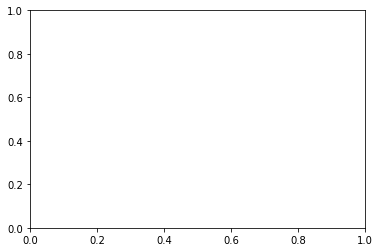

In [3]:
# %load ../neon_aop_hyperspectral.py
"""
Created on Wed Jun 20 10:34:49 2018

@author: bhass
"""

import matplotlib.pyplot as plt
import numpy as np
import h5py, os, copy

def aop_h5refl2array(refl_filename):
    """aop_h5refl2array reads in a NEON AOP reflectance hdf5 file and returns 
           1. reflectance array (with the no data value and reflectance scale factor applied)
           2. dictionary of metadata including spatial information, and wavelengths of the bands
    --------
    Parameters
        refl_filename -- full or relative path and name of reflectance hdf5 file
    --------
    Returns 
    --------
    reflArray:
        array of reflectance values
    metadata:
        dictionary containing the following metadata:
            bad_band_window1 (tuple)
            bad_band_window2 (tuple)
            bands: # of bands (float)
            data ignore value: value corresponding to no data (float)
            epsg: coordinate system code (float)
            map info: coordinate system, datum & ellipsoid, pixel dimensions, and origin coordinates (string)
            reflectance scale factor: factor by which reflectance is scaled (float)
            wavelength: wavelength values (float)
            wavelength unit: 'm' (string)
    --------
    NOTE: This function applies to the NEON hdf5 format implemented in 2016, and should be used for
    data acquired 2016 and after. Data in earlier NEON hdf5 format (collected prior to 2016) is 
    expected to be re-processed after the 2018 flight season. 
    --------
    Example Execution:
    --------
    sercRefl, sercRefl_metadata = h5refl2array('NEON_D02_SERC_DP3_368000_4306000_reflectance.h5') """
    
    import h5py
    
    #Read in reflectance hdf5 file 
    hdf5_file = h5py.File(refl_filename,'r')

    #Get the site name
    file_attrs_string = str(list(hdf5_file.items()))
    file_attrs_string_split = file_attrs_string.split("'")
    sitename = file_attrs_string_split[1]
    
    #Extract the reflectance & wavelength datasets
    refl = hdf5_file[sitename]['Reflectance']
    reflData = refl['Reflectance_Data']
    reflRaw = refl['Reflectance_Data'].value
    
    #Create dictionary containing relevant metadata information
    metadata = {}
    metadata['map info'] = refl['Metadata']['Coordinate_System']['Map_Info'].value
    metadata['wavelength'] = refl['Metadata']['Spectral_Data']['Wavelength'].value

    #Extract no data value & scale factor
    metadata['data ignore value'] = float(reflData.attrs['Data_Ignore_Value'])
    metadata['reflectance scale factor'] = float(reflData.attrs['Scale_Factor'])
    #metadata['interleave'] = reflData.attrs['Interleave']
    
    #Apply no data value
    reflClean = reflRaw.astype(float)
    arr_size = reflClean.shape
    if metadata['data ignore value'] in reflRaw:
        print('% No Data: ',np.round(np.count_nonzero(reflClean==metadata['data ignore value'])*100/(arr_size[0]*arr_size[1]*arr_size[2]),1))
        nodata_ind = np.where(reflClean==metadata['data ignore value'])
        reflClean[nodata_ind]=np.nan 
    
    #Apply scale factor
    reflArray = reflClean/metadata['reflectance scale factor']
    
    #Extract spatial extent from attributes
    metadata['spatial extent'] = reflData.attrs['Spatial_Extent_meters']
    
    #Extract bad band windows
    metadata['bad band window1'] = (refl.attrs['Band_Window_1_Nanometers'])
    metadata['bad band window2'] = (refl.attrs['Band_Window_2_Nanometers'])
    
    #Extract projection information
    #metadata['projection'] = refl['Metadata']['Coordinate_System']['Proj4'].value
    metadata['epsg'] = int(refl['Metadata']['Coordinate_System']['EPSG Code'].value)
    
    #Extract map information: spatial extent & resolution (pixel size)
    mapInfo = refl['Metadata']['Coordinate_System']['Map_Info'].value
    
    hdf5_file.close        
    
    return reflArray, metadata

def plot_aop_refl(band_array,refl_extent,colorlimit=(0,1),ax=plt.gca(),title='',cbar ='on',cmap_title='',colormap='Greys'):
    
    '''plot_refl_data reads in and plots a single band or 3 stacked bands of a reflectance array
    --------
    Parameters
    --------
        band_array: array of reflectance values, created from aop_h5refl2array
        refl_extent: extent of reflectance data to be plotted (xMin, xMax, yMin, yMax) 
                     use metadata['spatial extent'] from aop_h5refl2array function
        colorlimit: optional, range of values to plot (min,max). 
                    - helpful to look at the histogram of reflectance values before plotting to determine colorlimit.
        ax: optional, default = current axis
        title: optional; plot title (string)
        cmap_title: optional; colorbar title 
        colormap: optional (string, see https://matplotlib.org/examples/color/colormaps_reference.html) for list of colormaps
    --------
    Returns 
    --------
        plots flightline array of single band of reflectance data
    --------

    Examples:
    --------
    plot_aop_refl(sercb56,
              sercMetadata['spatial extent'],
              colorlimit=(0,0.3),
              title='SERC Band 56 Reflectance',
              cmap_title='Reflectance',
              colormap='Greys_r') '''
    
    import matplotlib.pyplot as plt
    
    plot = plt.imshow(band_array,extent=refl_extent,clim=colorlimit); 
    if cbar == 'on':
        cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
        cbar.set_label(cmap_title,rotation=90,labelpad=20)
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); #do not use scientific notation for ticklabels
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90); #rotate x tick labels 90 degrees
    
def stack_rgb(reflArray,bands):
    
    red = reflArray[:,:,bands[0]-1]
    green = reflArray[:,:,bands[1]-1]
    blue = reflArray[:,:,bands[2]-1]
    
    stackedRGB = np.stack((red,green,blue),axis=2)
    
    return stackedRGB

def plot_aop_rgb(rgbArray,ext,ls_pct=5,plot_title=''):
    
    from skimage import exposure
    
    pLow, pHigh = np.percentile(rgbArray[~np.isnan(rgbArray)], (ls_pct,100-ls_pct))
    img_rescale = exposure.rescale_intensity(rgbArray, in_range=(pLow,pHigh))
    plt.imshow(img_rescale,extent=ext)
    plt.title(plot_title + '\n Linear ' + str(ls_pct) + '% Contrast Stretch'); 
    ax = plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degree

### Read in SERC Reflectance Tile

In [4]:
sercRefl, sercRefl_md = aop_h5refl2array('../data/Day1_Hyperspectral_Intro/NEON_D02_SERC_DP3_368000_4306000_reflectance.h5')

### Extract NIR and VIS bands

Now that we have uploaded all the required functions, we can calculate NDVI and plot it. 
Below we print the center wavelengths that these bands correspond to:

In [5]:
print('band 58 center wavelength (nm): ',sercRefl_md['wavelength'][57])
print('band 90 center wavelength (nm) : ', sercRefl_md['wavelength'][89])

band 58 center wavelength (nm):  668.985
band 90 center wavelength (nm) :  829.238


## Calculate & Plot NDVI

Here we see that band 58 represents red visible light, while band 90 is in the NIR portion of the spectrum. Let's extract these two bands from the reflectance array and calculate the ratio using the `numpy.divide` which divides arrays element-wise. 

In [6]:
vis = sercRefl[:,:,57]
nir = sercRefl[:,:,89]

ndvi = np.divide((nir-vis),(nir+vis))

We can use the function `plot_aop_refl` to plot this, and choose the `seismic` color pallette to highlight the difference between positive and negative NDVI values. Since this is a normalized index, the values should range from -1 to +1. 

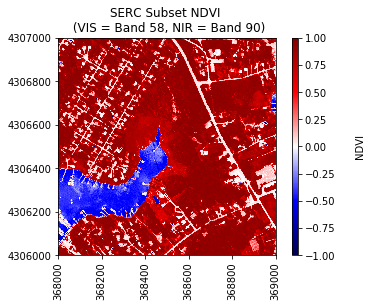

In [7]:
plot_aop_refl(ndvi,sercRefl_md['spatial extent'],
              colorlimit = (np.min(ndvi),np.max(ndvi)),
              title='SERC Subset NDVI \n (VIS = Band 58, NIR = Band 90)',
              cmap_title='NDVI',
              colormap='seismic')

## Extract Spectra Using Masks

In the second part of this tutorial, we will learn how to extract the average spectra of pixels whose NDVI exceeds a specified threshold value. There are several ways to do this using `numpy`, including the mask functions `numpy.ma`, as well as `numpy.where` and finally using `boolean` indexing. 

To start, lets copy the NDVI calculated above and use booleans to create an array only containing NDVI > 0.6.

In [8]:
import copy
ndvi_gtpt6 = copy.copy(ndvi)
#set all pixels with NDVI < 0.6 to nan, keeping only values > 0.6
ndvi_gtpt6[ndvi<0.6] = np.nan  
print('Mean NDVI > 0.6:',round(np.nanmean(ndvi_gtpt6),2))

Mean NDVI > 0.6: 0.87


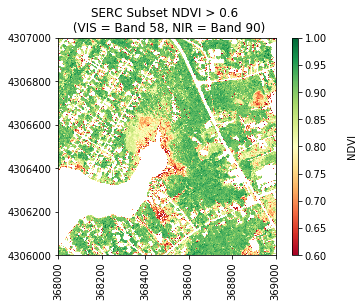

In [8]:
plot_aop_refl(ndvi_gtpt6,
                sercRefl_md['spatial extent'],
                colorlimit=(0.6,1),
                title='SERC Subset NDVI > 0.6 \n (VIS = Band 58, NIR = Band 90)',
                cmap_title='NDVI',
                colormap='RdYlGn')

## Calculate the mean spectra, thresholded by NDVI 
Below we will demonstrate how to calculate statistics on arrays where you have applied a mask `numpy.ma`. In this example, the function calculates the mean spectra for values that remain after masking out values by a specified threshold. 

In [9]:
import numpy.ma as ma
def calculate_mean_masked_spectra(reflArray,ndvi,ndvi_threshold,ineq='>'):
    
    mean_masked_refl = np.zeros(reflArray.shape[2])
    
    for i in np.arange(reflArray.shape[2]):
        refl_band = reflArray[:,:,i]
        
        if ineq == '>':
            ndvi_mask = ma.masked_where((ndvi<=ndvi_threshold) | (np.isnan(ndvi)),ndvi)
        elif ineq == '<':
            ndvi_mask = ma.masked_where((ndvi>=ndvi_threshold) | (np.isnan(ndvi)),ndvi)   
        else:
            print('ERROR: Invalid inequality. Enter < or >')
            
        masked_refl = ma.MaskedArray(refl_band,mask=ndvi_mask.mask)
        mean_masked_refl[i] = ma.mean(masked_refl)
            
    return mean_masked_refl

We can test out this function for various NDVI thresholds. We'll test two together, and you can try out different values on your own. Let's look at the average spectra for healthy vegetation (NDVI > 0.6), and for a lower threshold (NDVI < 0.3).

In [10]:
sercSpectra_ndvi_gtpt6 = calculate_mean_masked_spectra(sercRefl,ndvi,0.6)
sercSpectra_ndvi_ltpt3 = calculate_mean_masked_spectra(sercRefl,ndvi,0.3,ineq='<') 

Finally, we can use `pandas` to plot the mean spectra. First set up the pandas dataframe.

In [11]:
import pandas

#Remove water vapor bad band windows & last 10 bands 
w = copy.copy(sercRefl_md['wavelength'])
w[((w >= 1340) & (w <= 1445)) | ((w >= 1790) & (w <= 1955))]=np.nan
w[-10:]=np.nan;  

nan_ind = np.argwhere(np.isnan(w))

sercSpectra_ndvi_gtpt6[nan_ind] = np.nan
sercSpectra_ndvi_ltpt3[nan_ind] = np.nan

#Create dataframe with masked NDVI mean spectra
sercSpectra_ndvi_df = pandas.DataFrame()
sercSpectra_ndvi_df['wavelength'] = w
sercSpectra_ndvi_df['mean_refl_ndvi_gtpt6'] = sercSpectra_ndvi_gtpt6
sercSpectra_ndvi_df['mean_refl_ndvi_ltpt3'] = sercSpectra_ndvi_ltpt3

Plot the masked NDVI dataframe to display the mean spectra for NDVI values that exceed 0.6 and that are less than 0.3:

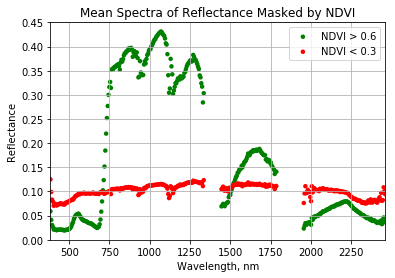

In [12]:
ax = plt.gca();
sercSpectra_ndvi_df.plot(ax=ax,x='wavelength',y='mean_refl_ndvi_gtpt6',color='green',
                         edgecolor='none',kind='scatter',label='NDVI > 0.6',legend=True);
sercSpectra_ndvi_df.plot(ax=ax,x='wavelength',y='mean_refl_ndvi_ltpt3',color='red',
                         edgecolor='none',kind='scatter',label='NDVI < 0.3',legend=True);
ax.set_title('Mean Spectra of Reflectance Masked by NDVI')
ax.set_xlim([np.nanmin(w),np.nanmax(w)]); ax.set_ylim(0,0.45)
ax.set_xlabel("Wavelength, nm"); ax.set_ylabel("Reflectance")
ax.grid('on'); 